In [ ]:
import os
import requests
import tarfile

# Define the URL of the Speech Commands dataset (v0.02)
dataset_url = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
dataset_path = '/content/speech_commands_v0.02.tar.gz'
extract_path = '/content/speech_commands_v0.02/'

# Download the dataset from the URL
print("Downloading dataset...")
response = requests.get(dataset_url, stream=True)

# Write the downloaded content to a file
with open(dataset_path, 'wb') as f:
    f.write(response.raw.read())
print("Download completed.")

# Extract the tar.gz file
print("Extracting dataset...")
with tarfile.open(dataset_path, "r:gz") as tar:
    tar.extractall(extract_path)
print("Extraction completed.")

# Verify the extraction
print("Files and directories in the dataset folder:")
print(os.listdir(extract_path))


Download completed.
Extracting dataset...
Extraction completed.
Files and directories in the dataset folder:
['no', 'right', 'left', 'zero', 'seven', 'forward', 'six', '_background_noise_', 'two', 'wow', 'happy', 'four', 'one', 'down', 'sheila', 'learn', 'go', 'bed', 'validation_list.txt', 'yes', 'on', 'house', 'bird', '.DS_Store', 'nine', 'stop', 'three', 'up', 'dog', 'backward', 'testing_list.txt', 'tree', 'LICENSE', 'five', 'marvin', 'README.md', 'off', 'eight', 'cat', 'follow', 'visual']


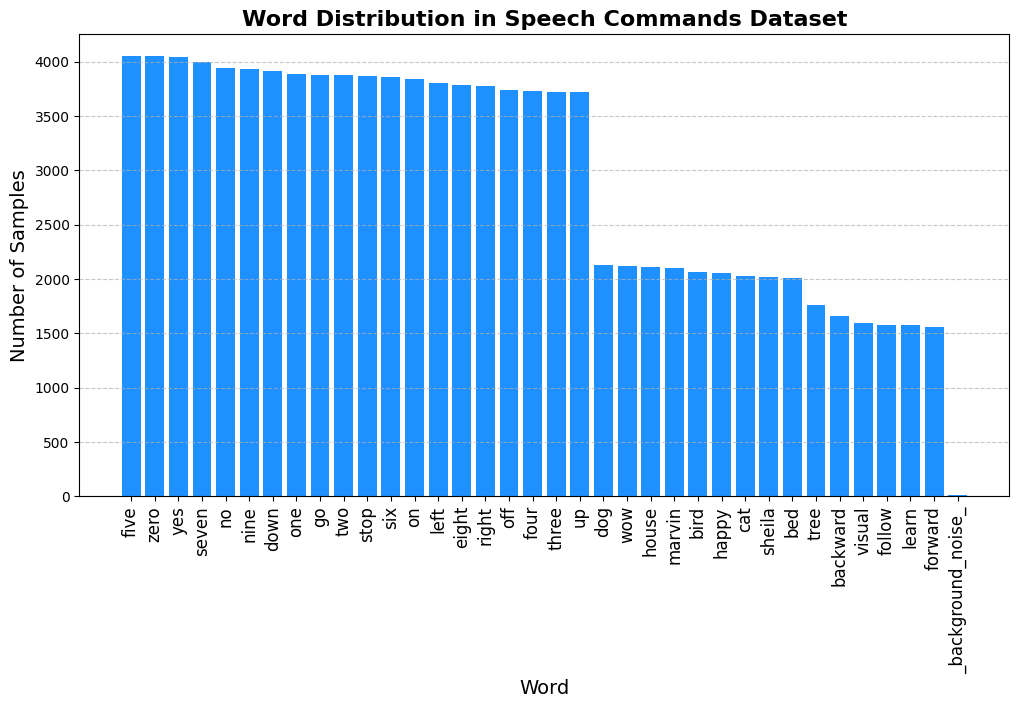

             Count
count    36.000000
mean   2939.888889
std    1114.680781
min       7.000000
25%    2028.750000
50%    3727.500000
75%    3880.000000
max    4052.000000


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# List word labels in the dataset
word_labels = [d for d in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, d))]

# Count the number of audio files per word label
word_counts = {}
for word in word_labels:
    word_counts[word] = len(os.listdir(os.path.join(extract_path, word)))

# Convert to DataFrame for easier visualization
word_counts_df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Count'])
word_counts_df = word_counts_df.sort_values(by='Count', ascending=False)

# Plot word distribution
plt.figure(figsize=(12,6))
plt.bar(word_counts_df['Word'], word_counts_df['Count'], color='dodgerblue')
plt.xticks(rotation=90, fontsize=12)
plt.title('Word Distribution in Speech Commands Dataset', fontsize=16, weight='bold')
plt.xlabel('Word', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display statistics
print(word_counts_df.describe())


In [ ]:
import glob

# List all audio files in the dataset
all_audio_files = glob.glob(extract_path + '**/*.wav', recursive=True)

# Extract speaker IDs (file path format includes speaker IDs)
speakers = [os.path.basename(file).split('_')[0] for file in all_audio_files]

# Get unique speaker count
unique_speakers = set(speakers)
print(f"Total number of unique speakers: {len(unique_speakers)}")


Total number of unique speakers: 2624


Audio length statistics (in samples):
count    1.058350e+05
mean     1.575438e+04
std      8.131833e+03
min      3.413000e+03
25%      1.600000e+04
50%      1.600000e+04
75%      1.600000e+04
max      1.522930e+06
dtype: float64


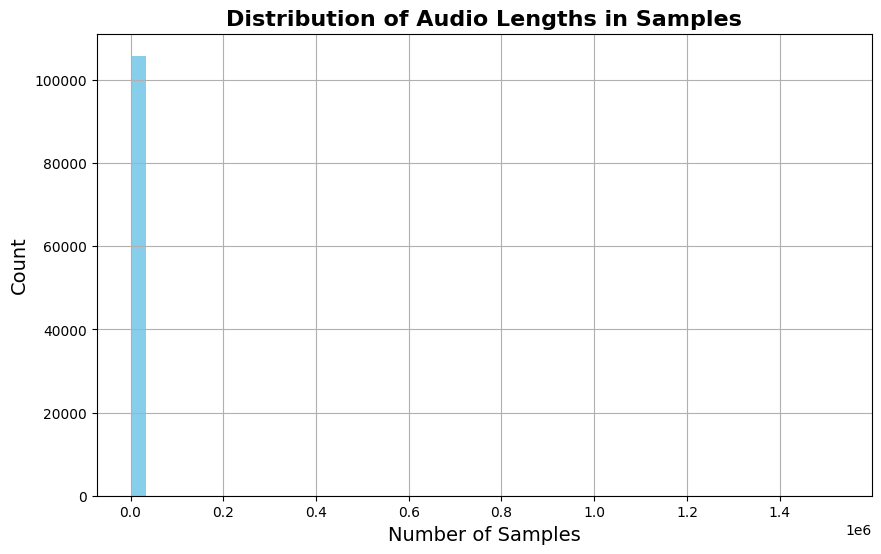

In [ ]:
import torchaudio

# Check if all audio files are 1 second long (16000 samples)
durations = []
for file in all_audio_files:
    waveform, sample_rate = torchaudio.load(file)
    durations.append(waveform.shape[1])

# Calculate statistics
durations = pd.Series(durations)
print("Audio length statistics (in samples):")
print(durations.describe())

# Plot audio lengths
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=50, color='skyblue')
plt.title("Distribution of Audio Lengths in Samples", fontsize=16, weight='bold')
plt.xlabel("Number of Samples", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(True)
plt.show()


In [ ]:
# Verify the sample rate of the files
sample_rates = set()
for file in all_audio_files:
    waveform, sample_rate = torchaudio.load(file)
    sample_rates.add(sample_rate)

# Output unique sample rates
print(f"Unique sample rates in the dataset: {sample_rates}")


Unique sample rates in the dataset: {16000}


Padded MFCC shape: (100, 13, 98)
MFCC mean: -6.4112348556518555
MFCC standard deviation: 44.699073791503906


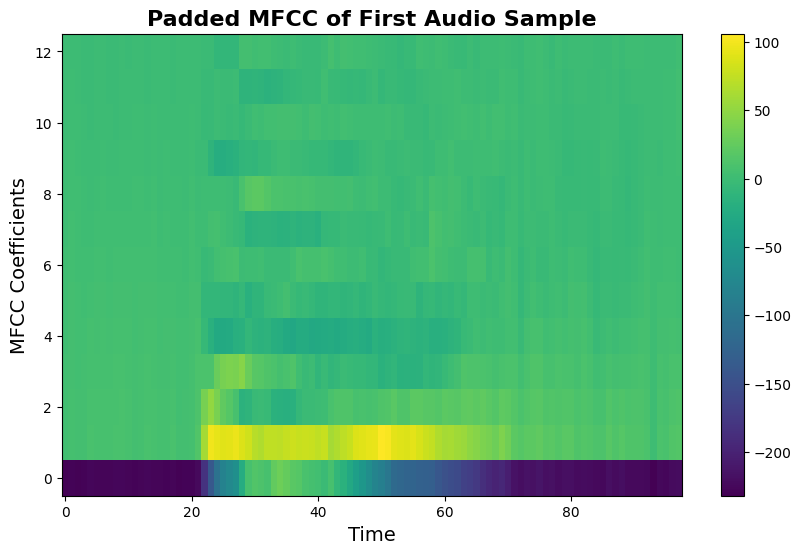

In [ ]:
import torchaudio.transforms as transforms
import numpy as np

# Define a transform to extract MFCC features
mfcc_transform = transforms.MFCC(
    sample_rate=16000,
    n_mfcc=13,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False}
)

# Function to pad MFCCs to the maximum length
def pad_mfcc(mfcc, max_length):
    """Pads the MFCC array with zeros to match the max length."""
    if mfcc.shape[-1] < max_length:
        padding = max_length - mfcc.shape[-1]
        # Only pad along the time dimension (second axis)
        mfcc = np.pad(mfcc, ((0, 0), (0, padding)), mode='constant')
    return mfcc

# Analyze MFCC features for the first 100 samples
mfccs = []
max_mfcc_length = 0

# First, find the maximum MFCC length in the first 100 samples
for file in all_audio_files[:100]:
    waveform, sample_rate = torchaudio.load(file)
    mfcc = mfcc_transform(waveform)
    mfcc = mfcc.squeeze(0)  # Remove the batch dimension if it exists
    mfccs.append(mfcc.numpy())
    max_mfcc_length = max(max_mfcc_length, mfcc.shape[-1])

# Pad MFCCs to have the same length
padded_mfccs = [pad_mfcc(mfcc, max_mfcc_length) for mfcc in mfccs]

# Convert to numpy array for easier analysis
padded_mfccs = np.array(padded_mfccs)

# Print MFCC shape and basic statistics
print(f"Padded MFCC shape: {padded_mfccs.shape}")
print(f"MFCC mean: {padded_mfccs.mean()}")
print(f"MFCC standard deviation: {padded_mfccs.std()}")

# Plot MFCC for one sample
plt.figure(figsize=(10, 6))
plt.imshow(padded_mfccs[0], origin="lower", aspect="auto", cmap="viridis")
plt.title("Padded MFCC of First Audio Sample", fontsize=16, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('MFCC Coefficients', fontsize=14)
plt.colorbar()
plt.show()


Energy statistics:
count     100.000000
mean      139.081831
std       300.037499
min         1.595852
25%        23.221458
50%        58.243097
75%       145.091290
max      2640.947998
dtype: float64


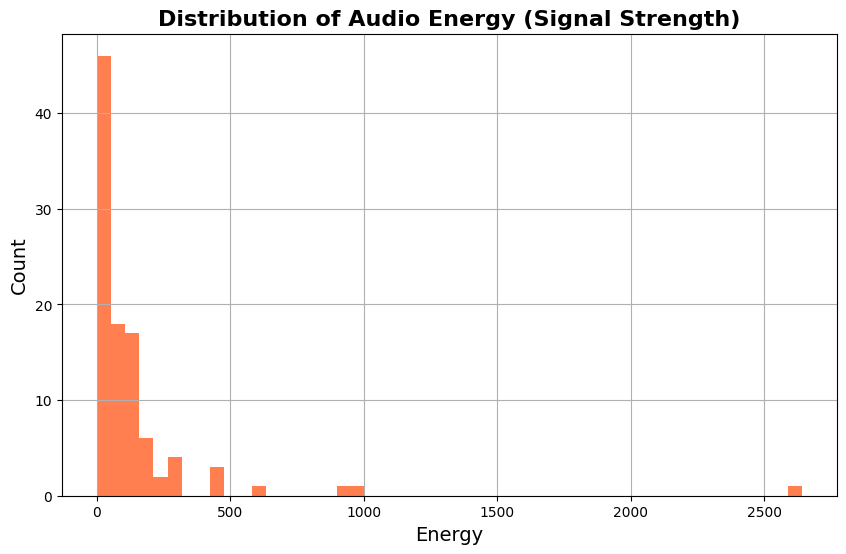

In [ ]:
# Analyze noise levels by checking the energy of the waveform
energy = []
for file in all_audio_files[:100]:
    waveform, sample_rate = torchaudio.load(file)
    energy.append((waveform ** 2).sum().item())

# Convert to Series for statistics
energy = pd.Series(energy)
print("Energy statistics:")
print(energy.describe())

# Plot energy distribution
plt.figure(figsize=(10, 6))
plt.hist(energy, bins=50, color='coral')
plt.title("Distribution of Audio Energy (Signal Strength)", fontsize=16, weight='bold')
plt.xlabel("Energy", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(True)
plt.show()
